In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skewtest
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [3]:
import pandas as pd

data = pd.read_csv("/Users/tomcooklin/Desktop/subset.csv")

for col in data.columns:
    print(col)

Unnamed: 0
SERIALNO
REGION.x
ST.x
HINCP
ADJINC.x
WGTP
PWGTP
AGEP
RAC1P
RAC2P
RACBLK
RACWHT
RELSHIPP
SEX
PINCP
PUMA.x
SCHL
COW
SOCP
DIVISION.x
REGION.x.1
WAOB
INCOME


In [4]:
data = data.iloc[: , 1:]

data = data.rename(columns={"REGION.x": "REGION", "ST.x": "ST", "ADJINC.x": "ADJINC", "PUMA.x": "PUMA", "DIVISION.x": "DIVISION", "REGION.x.1": "REGION"})

data = data[data.AGEP > 17]

data = data[data.INCOME > 15080]
#minimum full time wage

#unemployed or unpaid
data = data[data.COW != 8]
data = data[data.COW != 9]

data.head()

,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,RAC1P,RAC2P,...,SEX,PINCP,PUMA,SCHL,COW,SOCP,DIVISION,REGION,WAOB,INCOME
3,2021GQ0000005,4,6,NaN,1029928,0,177,26,White,1,...,1,15000,3741,1,NaN,NaN,9,4,1,15448.9200
4,2021GQ0000006,4,6,NaN,1029928,0,14,80,White,1,...,2,14800,11102,21,NaN,NaN,9,4,1,15242.9344
9,2021GQ0000011,4,53,NaN,1029928,0,65,79,White,1,...,2,40600,10100,19,NaN,NaN,9,4,1,41815.0768
11,2021GQ0000015,4,32,NaN,1029928,0,166,20,Black,2,...,1,22800,103,14,1.0,5120XX,8,4,1,23482.3584
14,2021GQ0000020,3,37,NaN,1029928,0,78,21,White,1,...,1,37400,5002,19,5.0,1940YY,5,3,1,38519.3072


In [5]:
print(data['COW'].value_counts())

1.0    917038
2.0    137942
3.0    129778
6.0     91369
4.0     68805
7.0     64138
5.0     59711
Name: COW, dtype: int64


In [6]:
educ_mapping = {1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:1,
                13:1,14:1,15:1,16:1,17:1,18:2,19:2,20:2,21:2,22:3,23:3,24:3}
data = data.assign(SCHL_recoded  = data.SCHL.map(educ_mapping))

#1 = <college, 2 = college, 3 = >college

cow_mapping = {1:"private for-profit", 2:"private non-profit", 3:"government", 4:"government", 5:"government", 6:"self employed", 7:"self employed"}
data = data.assign(COW_recoded  = data.COW.map(cow_mapping))

data.head()

,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,RAC1P,RAC2P,...,PUMA,SCHL,COW,SOCP,DIVISION,REGION,WAOB,INCOME,SCHL_recoded,COW_recoded
3,2021GQ0000005,4,6,NaN,1029928,0,177,26,White,1,...,3741,1,NaN,NaN,9,4,1,15448.9200,1,NaN
4,2021GQ0000006,4,6,NaN,1029928,0,14,80,White,1,...,11102,21,NaN,NaN,9,4,1,15242.9344,2,NaN
9,2021GQ0000011,4,53,NaN,1029928,0,65,79,White,1,...,10100,19,NaN,NaN,9,4,1,41815.0768,2,NaN
11,2021GQ0000015,4,32,NaN,1029928,0,166,20,Black,2,...,103,14,1.0,5120XX,8,4,1,23482.3584,1,private for-profit
14,2021GQ0000020,3,37,NaN,1029928,0,78,21,White,1,...,5002,19,5.0,1940YY,5,3,1,38519.3072,2,government


## Median vs Mean

In [7]:
skewtest(data.dropna()["INCOME"])

SkewtestResult(statistic=970.6619316907912, pvalue=0.0)

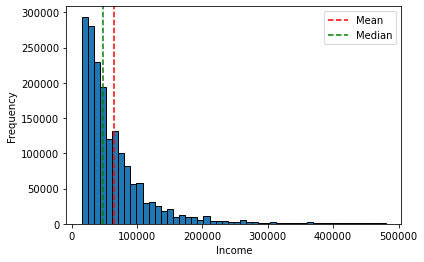

In [8]:
datag = data[data['INCOME'] < data['INCOME'].quantile(0.99)]
plt.hist(datag["INCOME"], bins=50, edgecolor='black')
plt.xlabel('Income')
plt.ylabel('Frequency')
median = np.median(datag['INCOME'])
mean = np.mean(datag['INCOME'])
plt.axvline(x=mean, color='red', linestyle='--', label='Mean')
plt.axvline(x=median, color='green', linestyle='--', label = 'Median')
plt.legend()
plt.show()

We use median to reduce the affect of high income outliers

In [9]:
pincp_data = data.groupby('PUMA').agg({'INCOME':np.median}).reset_index()

pincp_data.head()

,PUMA,INCOME
0,100,42021.0624
1,101,51496.4000
2,102,52526.3280
3,103,56646.0400
4,104,46346.7600


In [10]:
pincp_data.rename(columns={"INCOME": "income_median_PUMA"}, inplace = True)

pincp_data.head()

,PUMA,income_median_PUMA
0,100,42021.0624
1,101,51496.4000
2,102,52526.3280
3,103,56646.0400
4,104,46346.7600


In [11]:
data = data.merge(pincp_data, on='PUMA', how='left')

data["income_percent"] = data["INCOME"] / data["income_median_PUMA"]

data.head()

,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,RAC1P,RAC2P,...,COW,SOCP,DIVISION,REGION,WAOB,INCOME,SCHL_recoded,COW_recoded,income_median_PUMA,income_percent
0,2021GQ0000005,4,6,NaN,1029928,0,177,26,White,1,...,NaN,NaN,9,4,1,15448.9200,1,NaN,32957.6960,0.468750
1,2021GQ0000006,4,6,NaN,1029928,0,14,80,White,1,...,NaN,NaN,9,4,1,15242.9344,2,NaN,51805.3784,0.294235
2,2021GQ0000011,4,53,NaN,1029928,0,65,79,White,1,...,NaN,NaN,9,4,1,41815.0768,2,NaN,45316.8320,0.922727
3,2021GQ0000015,4,32,NaN,1029928,0,166,20,Black,2,...,1.0,5120XX,8,4,1,23482.3584,1,private for-profit,56646.0400,0.414545
4,2021GQ0000020,3,37,NaN,1029928,0,78,21,White,1,...,5.0,1940YY,5,3,1,38519.3072,2,government,33987.6240,1.133333


## Lorenz Curve

In [12]:
data = data.sort_values(by=['INCOME']).reset_index()
data = data.sort_values(by=['INCOME']).reset_index()

In [13]:
data["cum_sum"] = data["INCOME"].cumsum() / data["INCOME"].sum()
data["cumu"] = data["level_0"] / max(data["level_0"])

In [14]:
data.head()

,level_0,index,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,...,DIVISION,REGION,WAOB,INCOME,SCHL_recoded,COW_recoded,income_median_PUMA,income_percent,cum_sum,cumu
0,0,1103857,2021HU0859830,3,12,33050.0,1029928,32,36,90,...,5,3,3,15088.4452,1,NaN,53556.256,0.281731,1.197007e-07,0.000000
1,28,1125779,2021HU0877462,3,54,42750.0,1029928,226,192,27,...,5,3,1,15088.4452,2,private non-profit,43256.976,0.348810,2.394014e-07,0.000016
2,27,1379983,2021HU1081113,3,21,66650.0,1029928,498,497,30,...,6,3,1,15088.4452,1,private for-profit,45316.832,0.332955,3.591021e-07,0.000015
3,26,1286968,2021HU1006891,1,42,45250.0,1029928,292,292,83,...,2,1,1,15088.4452,1,NaN,50466.472,0.298980,4.788028e-07,0.000014
4,24,57796,2021HU0021907,2,26,34900.0,1029928,71,71,62,...,3,2,1,15088.4452,2,NaN,44286.904,0.340698,5.985035e-07,0.000013


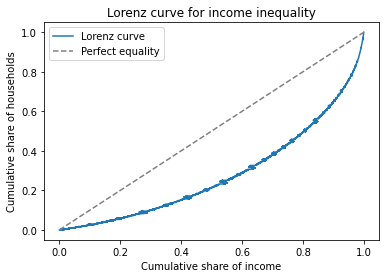

In [15]:
fig, ax = plt.subplots()
ax.plot(data["cumu"], data["cum_sum"], label='Lorenz curve')
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Perfect equality')
ax.set_xlabel('Cumulative share of income')
ax.set_ylabel('Cumulative share of households')
ax.set_title('Lorenz curve for income inequality')
ax.legend()
plt.show()

## Individual Model

In [16]:
data.isna().sum()

level_0                    0
index                      0
SERIALNO                   0
REGION                     0
ST                         0
HINCP                  30355
ADJINC                     0
WGTP                       0
PWGTP                      0
AGEP                       0
RAC1P                      0
RAC2P                      0
RACBLK                     0
RACWHT                     0
RELSHIPP                   0
SEX                        0
PINCP                      0
PUMA                       0
SCHL                       0
COW                   328660
SOCP                  328660
DIVISION                   0
REGION                     0
WAOB                       0
INCOME                     0
SCHL_recoded               0
COW_recoded           328660
income_median_PUMA         0
income_percent             0
cum_sum                    0
cumu                       0
dtype: int64

In [17]:
from statsmodels.formula.api import ols

data2=data.dropna(subset=['AGEP', 'RACBLK', 'RACWHT', 'SEX', 'income_percent'])

model = ols(formula='income_percent ~ AGEP + RACBLK + RACWHT + SEX', data=data2)
print(type(model))

<class 'statsmodels.regression.linear_model.OLS'>


In [18]:
model = model.fit()
print(type(model))
print(model.summary())

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
                            OLS Regression Results                            
Dep. Variable:         income_percent   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                 1.108e+04
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        18:11:29   Log-Likelihood:            -3.2863e+06
No. Observations:             1797441   AIC:                         6.573e+06
Df Residuals:                 1797436   BIC:                         6.573e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

We see that the age of an individual increases income, if an individual is white rather than black and if the individual is male

# Clustering

In [19]:
data.isna().sum()

level_0                    0
index                      0
SERIALNO                   0
REGION                     0
ST                         0
HINCP                  30355
ADJINC                     0
WGTP                       0
PWGTP                      0
AGEP                       0
RAC1P                      0
RAC2P                      0
RACBLK                     0
RACWHT                     0
RELSHIPP                   0
SEX                        0
PINCP                      0
PUMA                       0
SCHL                       0
COW                   328660
SOCP                  328660
DIVISION                   0
REGION                     0
WAOB                       0
INCOME                     0
SCHL_recoded               0
COW_recoded           328660
income_median_PUMA         0
income_percent             0
cum_sum                    0
cumu                       0
dtype: int64

In [20]:
data = data[data['COW'].notna()]

data = data[data['SOCP'].notna()]

data.isna().sum()

level_0                   0
index                     0
SERIALNO                  0
REGION                    0
ST                        0
HINCP                 16389
ADJINC                    0
WGTP                      0
PWGTP                     0
AGEP                      0
RAC1P                     0
RAC2P                     0
RACBLK                    0
RACWHT                    0
RELSHIPP                  0
SEX                       0
PINCP                     0
PUMA                      0
SCHL                      0
COW                       0
SOCP                      0
DIVISION                  0
REGION                    0
WAOB                      0
INCOME                    0
SCHL_recoded              0
COW_recoded               0
income_median_PUMA        0
income_percent            0
cum_sum                   0
cumu                      0
dtype: int64

In [21]:
le = LabelEncoder()
RAC1P_encoded = le.fit_transform(data['RAC1P'])
print(RAC1P_encoded)

[3 1 2 ... 3 3 3]


In [22]:
data['RAC1P_encoded'] = RAC1P_encoded
data.head()

,level_0,index,SERIALNO,REGION,ST,HINCP,ADJINC,WGTP,PWGTP,AGEP,...,REGION,WAOB,INCOME,SCHL_recoded,COW_recoded,income_median_PUMA,income_percent,cum_sum,cumu,RAC1P_encoded
1,28,1125779,2021HU0877462,3,54,42750.0,1029928,226,192,27,...,3,1,15088.4452,2,private non-profit,43256.97600,0.348810,2.394014e-07,0.000016,3
2,27,1379983,2021HU1081113,3,21,66650.0,1029928,498,497,30,...,3,1,15088.4452,1,private for-profit,45316.83200,0.332955,3.591021e-07,0.000015,1
6,22,260342,2021HU0184000,3,48,34150.0,1029928,94,94,65,...,3,3,15088.4452,1,private for-profit,55616.11200,0.271296,8.379049e-07,0.000012,2
7,21,1696188,2021HU1334682,3,51,136550.0,1029928,78,24,64,...,3,1,15088.4452,1,self employed,54153.61424,0.278623,9.576056e-07,0.000012,2
8,20,69370,2021HU0031214,1,9,14650.0,1029928,74,73,61,...,1,1,15088.4452,2,self employed,42227.04800,0.357317,1.077306e-06,0.000011,3


In [23]:
data2 = data[['SCHL_recoded', 'RAC1P_encoded', 'INCOME', 'SEX', 'AGEP']]

kms = KMeans(n_clusters=3, random_state=1).fit(data2)
data2['Cluster'] = kms.labels_

data2.head()

/Users/tomcooklin/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/1387117931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Cluster'] = kms.labels_


,SCHL_recoded,RAC1P_encoded,INCOME,SEX,AGEP,Cluster
1,2,3,15088.4452,2,27,0
2,1,1,15088.4452,1,30,0
6,1,2,15088.4452,1,65,0
7,1,2,15088.4452,2,64,0
8,2,3,15088.4452,1,61,0


In [24]:
print(data2['Cluster'].value_counts())

0    1184413
1     254465
2      29903
Name: Cluster, dtype: int64


In [25]:
ran_samp = data2.sample(n=5000, random_state=1)

ran_samp.head()

,SCHL_recoded,RAC1P_encoded,INCOME,SEX,AGEP,Cluster
176092,1,0,20598.5600,2,34,0
1299596,3,3,74566.7872,2,51,0
1571291,2,3,115866.9000,1,27,1
1442166,3,3,92693.5200,2,56,0
1353110,2,1,80334.3840,1,53,0


Text(0, 0.5, 'Income')

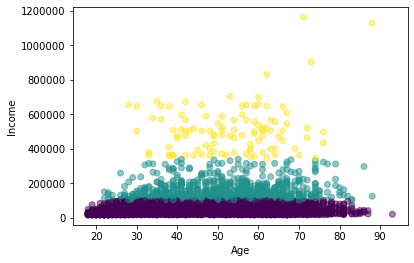

In [26]:
plt.scatter(ran_samp["AGEP"], ran_samp["INCOME"], c = ran_samp["Cluster"], alpha = 0.5)
plt.ticklabel_format(style='plain')
plt.xlabel('Age')
plt.ylabel('Income')

In [27]:
from sklearn.metrics import silhouette_score

ran_samp2 = ran_samp.drop('Cluster', axis=1)

silhouette_avg = silhouette_score(ran_samp2, ran_samp['Cluster'])
print(silhouette_avg)

0.6845055634179633


We can see that the clustering has partitioned the data largely on income. The Silhouette score is also good. We can now investigate the affecting variable behind income by looking at each cluster.

In [28]:
data2["RAC1P"] = data["RAC1P"]
data2["COW_recoded"] = data["COW_recoded"]

data2.groupby('Cluster').agg({'INCOME':np.median})

/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/2695602654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["RAC1P"] = data["RAC1P"]
/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/2695602654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["COW_recoded"] = data["COW_recoded"]


,INCOME
Cluster,
0,43050.9904
1,133890.6400
2,503634.7920


<AxesSubplot:ylabel='Cluster'>

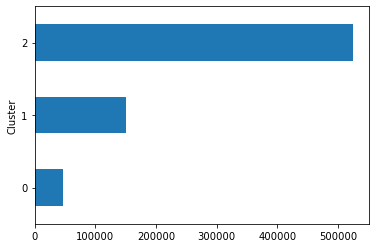

In [29]:
data2.groupby('Cluster').INCOME.mean().plot.barh()

<AxesSubplot:ylabel='Cluster'>

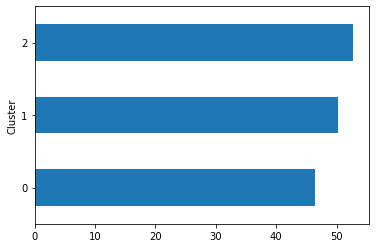

In [30]:
data2.groupby('Cluster').AGEP.mean().plot.barh()

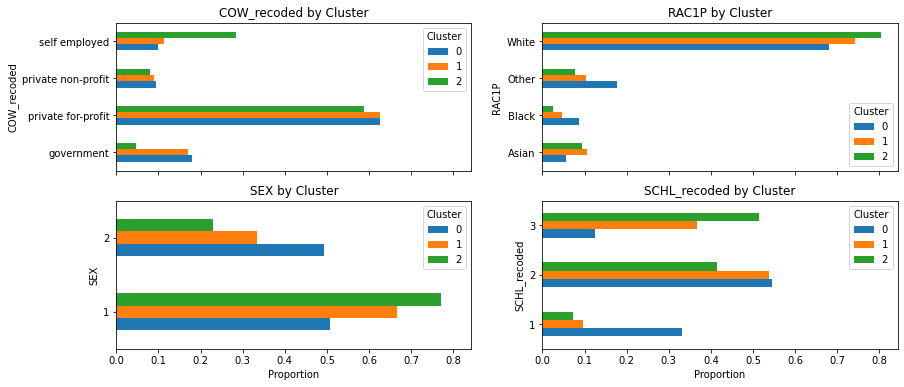

In [31]:
columns = ['COW_recoded', 'RAC1P', 'SEX', 'SCHL_recoded']


fig, axs = plt.subplots(2, 2, sharex=True, figsize=(14, 6))


for i, col in enumerate(columns):
    counts = data2.groupby(['Cluster', col])[col].count().unstack().div(data2.groupby('Cluster')[col].count(), axis=0)
    
    counts.T.plot(kind='barh', ax=axs[i//2, i%2])

    axs[i//2, i%2].set_xlabel('Proportion')
    axs[i//2, i%2].set_ylabel(col)
    axs[i//2, i%2].set_title(f'{col} by Cluster')

plt.show()

- Males (1) earn more than women (2). This is clear for higher income jobs but actually less significant than jobs with income around $200,000. At lower income jobs around 43,000 there is little disparity between sexes
- Highest income jobs are taken up by the individuals with the highest level of education. Lowest income jobs are mostly taken up by those who didn't attend college. In the middle cluster, there is actually more individual who didn't attend college than whose highest education level is college. This could be because people who didn't attend college make up the lowest income values of cluster 2.
- Most people work for private for-profit companies. A lot of individuals who are high earners are self employed.

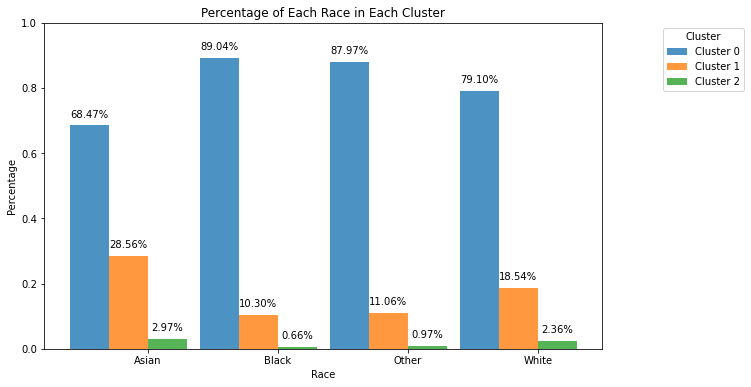

In [32]:
grouped = data2.groupby(['Cluster', 'RAC1P']).size().reset_index(name='count')
pivoted = grouped.pivot(index='RAC1P', columns='Cluster', values='count').fillna(0)
pivoted = pivoted.apply(lambda x: x / sum(x), axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3

for i, cluster in enumerate(pivoted.columns):
    values = pivoted[cluster]
    ax.bar(x=np.arange(len(pivoted)) + i * width - (len(pivoted.columns) / 2) * width, height=values, width=width, 
           color=f'C{i}', label=f'Cluster {cluster}', alpha=0.8)
    # add values to plot
    for j, race in enumerate(pivoted.index):
        value = pivoted.loc[race, cluster]
        ax.text(j + i * width - (len(pivoted.columns) / 2) * width, value+0.02, f'{value:.2%}', ha='center', va='bottom')
        
ax.set_xlabel('Race')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Race in Each Cluster')
plt.xticks(ticks=np.arange(len(pivoted)), labels=pivoted.index, rotation=0)
plt.legend(title='Cluster', bbox_to_anchor=(1.10, 1), loc='upper left')
ax.set_ylim([0, 1])
plt.show()

In [33]:
# Create the contingency table and reset the index
table_data = pd.crosstab(data2["RAC1P"], data2["Cluster"]).reset_index()

# Calculate the column totals
col_totals = table_data.sum(axis=0)[1:]

# Calculate the column proportions (proportions of each sex within all education levels)
col_props = table_data.iloc[:, 1:].div(col_totals, axis=1)

# Set the index back to the original values
col_props.index = table_data["RAC1P"]

# Print the contingency table with column proportions
print(col_props)
print("-------------------------------------------")
print(pd.crosstab(data2["RAC1P"], data2["Cluster"], margins = True))

Cluster         0         1         2
RAC1P                                
Asian     0.05492   0.10662  0.094506
Black    0.087656  0.047173   0.02575
Other    0.176765  0.103488  0.076848
White    0.680659  0.742719  0.802896
-------------------------------------------
Cluster        0       1      2      All
RAC1P                                   
Asian      65048   27131   2826    95005
Black     103821   12004    770   116595
Other     209363   26334   2298   237995
White     806181  188996  24009  1019186
All      1184413  254465  29903  1468781


In [34]:
chi2, pval, dof, expected = chi2_contingency(pd.crosstab(data2["RAC1P"], data2["Cluster"]))
print("Chi-squared statistic:", chi2)
print("p-value:", pval)
print("Degrees of freedom:", dof)
print("Expected values:")
print(expected)

Chi-squared statistic: 24499.20756598843
p-value: 0.0
Degrees of freedom: 6
Expected values:
[[ 76611.25590881  16459.53162861   1934.21246258]
 [ 94021.25554116  20199.9798983    2373.76456054]
 [191917.22383051  41232.42176676   4845.35440273]
 [821863.26471952 176573.06670634  20749.66857414]]


NOTE: The percentages for each race add up to 1, not each cluster

- The difference in race composition between each cluster is significant

- A greater proportion of Asians appear in the highest income cluster than any other race
- Most black  and other races are found in the poorest income cluster compared to other races. This is statistically significant 
- Asian people were also found more in the middle income cluster compared to other races


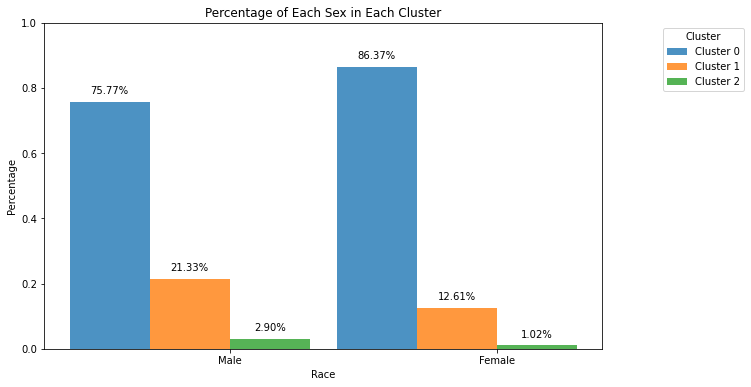

In [35]:
grouped = data2.groupby(['Cluster', 'SEX']).size().reset_index(name='count')
pivoted = grouped.pivot(index='SEX', columns='Cluster', values='count').fillna(0)
pivoted = pivoted.apply(lambda x: x / sum(x), axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3

for i, cluster in enumerate(pivoted.columns):
    values = pivoted[cluster]
    ax.bar(x=np.arange(len(pivoted)) + i * width - (len(pivoted.columns) / 2) * width, height=values, width=width, 
           color=f'C{i}', label=f'Cluster {cluster}', alpha=0.8)
    # add values to plot
    for j, race in enumerate(pivoted.index):
        value = pivoted.loc[race, cluster]
        ax.text(j + i * width - (len(pivoted.columns) / 2) * width, value+0.02, f'{value:.2%}', ha='center', va='bottom')
        
ax.set_xlabel('Race')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Sex in Each Cluster')
plt.xticks(ticks=np.arange(len(pivoted)), labels=['Male', 'Female'], rotation=0)
plt.legend(title='Cluster', bbox_to_anchor=(1.10, 1), loc='upper left')
ax.set_ylim([0, 1])
plt.show()

In [36]:
# Create the contingency table and reset the index
table_data = pd.crosstab(data2["Cluster"], data2["SEX"]).reset_index()

# Calculate the column totals
col_totals = table_data.sum(axis=0)[1:]

# Calculate the column proportions (proportions of each sex within all education levels)
col_props = table_data.iloc[:, 1:].div(col_totals, axis=1)

# Set the index back to the original values
col_props.index = table_data["Cluster"]

# Print the contingency table with column proportions
print(col_props)
print("-------------------------------------------")
print(pd.crosstab(data2["Cluster"], data2["SEX"], margins = True))

SEX             1         2
Cluster                    
0        0.757714  0.863729
1        0.213272  0.126107
2        0.029014  0.010165
-------------------------------------------
SEX           1       2      All
Cluster                         
0        601909  582504  1184413
1        169418   85047   254465
2         23048    6855    29903
All      794375  674406  1468781


In [37]:
chi2, pval, dof, expected = chi2_contingency(pd.crosstab(data2["Cluster"], data2["SEX"]))
print("Chi-squared statistic:", chi2)
print("p-value:", pval)
print("Degrees of freedom:", dof)
print("Expected values:")
print(expected)

Chi-squared statistic: 27445.077679399852
p-value: 0.0
Degrees of freedom: 2
Expected values:
[[640577.51078956 543835.48921044]
 [137624.76119653 116840.23880347]
 [ 16172.72801391  13730.27198609]]


In [38]:
# Define the number of successes and trials for each race category
successes = [601909, 582504] 
trials = [794375, 674406]   

# Perform the two-sample proportion test
zstat, pval = proportions_ztest(successes, trials)

# Print the test results
print("Z-score:", zstat)
print("p-value:", pval)

Z-score: -162.0419923867962
p-value: 0.0


- Difference between sexes in Cluster 0 is statistically significant

- The biggest difference between sexes is in the smaller income clusters. Females are represented more in the lowest income cluster than men and less in the larger income clusters

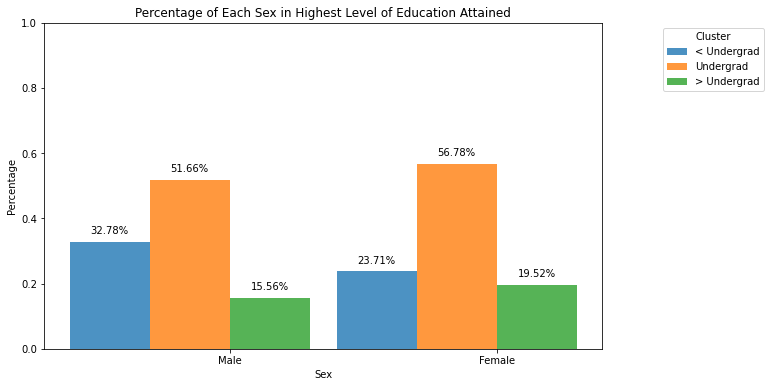

In [39]:
grouped = data2.groupby(['SCHL_recoded', 'SEX']).size().reset_index(name='count')
pivoted = grouped.pivot(index='SEX', columns='SCHL_recoded', values='count')
pivoted = pivoted.apply(lambda x: x / sum(x), axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3

pivoted = pivoted.rename(columns={1: '< Undergrad', 2: 'Undergrad', 3: '> Undergrad'})

for i, SCHL_recoded in enumerate(pivoted.columns):
    values = pivoted[SCHL_recoded]
    ax.bar(x=np.arange(len(pivoted)) + i * width - (len(pivoted.columns) / 2) * width, height=values, width=width, 
           color=f'C{i}', label=f'{SCHL_recoded}', alpha=0.8)
    # add values to plot
    for j, race in enumerate(pivoted.index):
        value = pivoted.loc[race, SCHL_recoded]
        ax.text(j + i * width - (len(pivoted.columns) / 2) * width, value+0.02, f'{value:.2%}', ha='center', va='bottom')
        
ax.set_xlabel('Sex')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Sex in Highest Level of Education Attained')
plt.xticks(ticks=np.arange(len(pivoted)), labels=['Male', 'Female'], rotation=0)
plt.legend(title='Cluster', bbox_to_anchor=(1.10, 1), loc='upper left')
ax.set_ylim([0, 1])
plt.show()

In [40]:
# Create the contingency table and reset the index
table_data = pd.crosstab(data2["SCHL_recoded"], data2["SEX"]).reset_index()

# Calculate the column totals
col_totals = table_data.sum(axis=0)[1:]

# Calculate the column proportions (proportions of each sex within all education levels)
col_props = table_data.iloc[:, 1:].div(col_totals, axis=1)

# Set the index back to the original values
col_props.index = table_data["SCHL_recoded"]

# Print the contingency table with column proportions
print(col_props)
print("-------------------------------------------")
print(pd.crosstab(data2["SCHL_recoded"], data2["SEX"], margins = True))

SEX                  1         2
SCHL_recoded                    
1             0.327761  0.237081
2             0.516630  0.567753
3             0.155609  0.195166
-------------------------------------------
SEX                1       2      All
SCHL_recoded                         
1             260365  159889   420254
2             410398  382896   793294
3             123612  131621   255233
All           794375  674406  1468781


In [41]:
chi2, pval, dof, expected = chi2_contingency(pd.crosstab(data2["SCHL_recoded"], data2["SEX"]))
print("Chi-squared statistic:", chi2)
print("p-value:", pval)
print("Degrees of freedom:", dof)
print("Expected values:")
print(expected)

Chi-squared statistic: 15531.595785726011
p-value: 0.0
Degrees of freedom: 2
Expected values:
[[227290.02570839 192963.97429161]
 [429044.84824491 364249.15175509]
 [138040.1260467  117192.8739533 ]]


In [42]:
# Define the number of successes and trials for each race category
successes = [410398, 382896] 
trials = [794375, 674406]   

# Perform the two-sample proportion test
zstat, pval = proportions_ztest(successes, trials)

# Print the test results
print("Z-score:", zstat)
print("p-value:", pval)

Z-score: -61.95008779089253
p-value: 0.0


- The result between men and women in college undergrad is statistically significant using a binomial test

- Women are actually more likely to attain college undergraduate degrees and post undergraduate degrees than men. Men are also more likely to have not received any college education

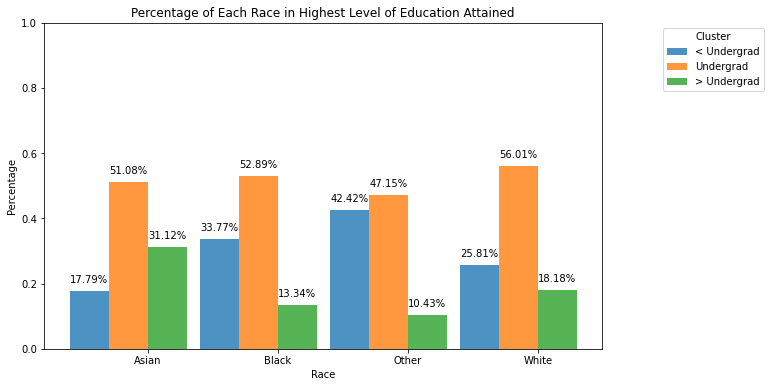

In [43]:
grouped = data2.groupby(['SCHL_recoded', 'RAC1P']).size().reset_index(name='count')
pivoted = grouped.pivot(index='RAC1P', columns='SCHL_recoded', values='count')
pivoted = pivoted.apply(lambda x: x / sum(x), axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.3

pivoted = pivoted.rename(columns={1: '< Undergrad', 2: 'Undergrad', 3: '> Undergrad'})

for i, SCHL_recoded in enumerate(pivoted.columns):
    values = pivoted[SCHL_recoded]
    ax.bar(x=np.arange(len(pivoted)) + i * width - (len(pivoted.columns) / 2) * width, height=values, width=width, 
           color=f'C{i}', label=f'{SCHL_recoded}', alpha=0.8)
    # add values to plot
    for j, race in enumerate(pivoted.index):
        value = pivoted.loc[race, SCHL_recoded]
        ax.text(j + i * width - (len(pivoted.columns) / 2) * width, value+0.02, f'{value:.2%}', ha='center', va='bottom')
        
ax.set_xlabel('Race')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Race in Highest Level of Education Attained')
plt.xticks(ticks=np.arange(len(pivoted)), labels=['Asian', 'Black', 'Other', 'White'], rotation=0)
plt.legend(title='Cluster', bbox_to_anchor=(1.10, 1), loc='upper left')
ax.set_ylim([0, 1])
plt.show()

In [44]:
# Create the contingency table and reset the index
table_data = pd.crosstab(data2["SCHL_recoded"], data2["RAC1P"]).reset_index()

# Calculate the column totals
col_totals = table_data.sum(axis=0)[1:]

# Calculate the column proportions (proportions of each race within all education levels)
col_props = table_data.iloc[:, 1:].div(col_totals, axis=1)

# Set the index back to the original values
col_props.index = table_data["SCHL_recoded"]

# Print the contingency table with column proportions
print(col_props)
print("-------------------------------------------")
print(pd.crosstab(data2["SCHL_recoded"], data2["RAC1P"], margins = True))

RAC1P            Asian     Black     Other     White
SCHL_recoded                                        
1             0.177949  0.337733  0.424194  0.258063
2             0.510815  0.528873  0.471514  0.560135
3             0.311236  0.133393  0.104292  0.181802
-------------------------------------------
RAC1P         Asian   Black   Other    White      All
SCHL_recoded                                         
1             16906   39378  100956   263014   420254
2             48530   61664  112218   570882   793294
3             29569   15553   24821   185290   255233
All           95005  116595  237995  1019186  1468781


In [45]:
chi2, pval, dof, expected = chi2_contingency(pd.crosstab(data2["SCHL_recoded"], data2["RAC1P"]))
print("Chi-squared statistic:", chi2)
print("p-value:", pval)
print("Degrees of freedom:", dof)
print("Expected values:")
print(expected)

Chi-squared statistic: 45055.53949852487
p-value: 0.0
Degrees of freedom: 6
Expected values:
[[ 27183.24329495  33360.66788037  68096.16323332 291613.92559136]
 [ 51312.54861685  62973.38672682 128541.97156009 550466.09309625]
 [ 16509.2080882   20260.94539281  41356.86520659 177105.98131239]]


- The results are significant

- The receival of undergraduate is consistent across all races. This may because of programs and incentives to include a diversity community in college undergrad. These programs tend to decrease for graduate level programs, hence why black and other races is considerably lower of post undergraduate degree.
- Black and other races are considerably more likely to not receieve a college education at all.
- Asians are far more likely to obtain post undergraduate educations than any other race. 

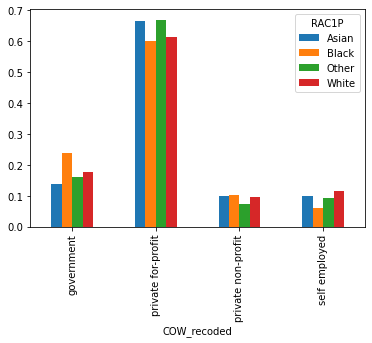

In [46]:
# Create the contingency table and reset the index
table_data = pd.crosstab(data2["COW_recoded"], data2["RAC1P"]).reset_index()

# Calculate the column totals
col_totals = table_data.sum(axis=0)[1:]

# Calculate the column proportions (proportions of each race within all education levels)
col_props = table_data.iloc[:, 1:].div(col_totals, axis=1)

# Set the index back to the original values
col_props.index = table_data["COW_recoded"]

ax = col_props.plot(kind='bar')

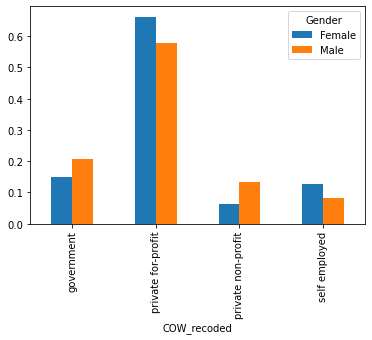

In [47]:
# Create the contingency table and reset the index
table_data = pd.crosstab(data2["COW_recoded"], data2["SEX"]).reset_index()

# Calculate the column totals
col_totals = table_data.sum(axis=0)[1:]

# Calculate the column proportions (proportions of each race within all education levels)
col_props = table_data.iloc[:, 1:].div(col_totals, axis=1)

# Set the index back to the original values
col_props.index = table_data["COW_recoded"]

ax = col_props.plot(kind='bar')
ax.legend(['Female', 'Male'], title='Gender')

In [48]:
data.groupby('COW_recoded')['INCOME'].mean()

COW_recoded
government            69031.197466
private for-profit    73964.789680
private non-profit    73741.575828
self employed         91058.183026
Name: INCOME, dtype: float64

- Females are also found more in better earning classes of work such as being self employed or working for a private for-profit company.
- Black people are more commonly found in goverment jobs which tend to earn the least.

# Feature Importance

In [49]:
data2.head()

,SCHL_recoded,RAC1P_encoded,INCOME,SEX,AGEP,Cluster,RAC1P,COW_recoded
1,2,3,15088.4452,2,27,0,White,private non-profit
2,1,1,15088.4452,1,30,0,Black,private for-profit
6,1,2,15088.4452,1,65,0,Other,private for-profit
7,1,2,15088.4452,2,64,0,Other,self employed
8,2,3,15088.4452,1,61,0,White,self employed


In [50]:
data2["COW_encoded"] = le.fit_transform(data2['COW_recoded'])

X = data2[["RAC1P_encoded", "SEX", "AGEP", "COW_encoded", "SCHL_recoded"]]
y = data2[["INCOME"]]

rf = RandomForestRegressor(n_estimators=30)
rf.fit(X, y)

/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/2147904457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["COW_encoded"] = le.fit_transform(data2['COW_recoded'])
/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/2147904457.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


RandomForestRegressor(n_estimators=30)

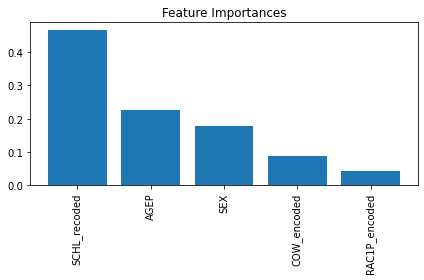

In [51]:
importances = rf.feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [52]:
data2['INCOME'].corr(data2['SCHL_recoded'])

0.2875762078514057

- This implies that level of education has a much largest impact on income, more than the race, age, sex and workplace of an individual. 
- An increase in education leads to an increase in income.
- Previously, we saw that females and Asian individuals are more educated than other individuals. Asians are found more in higher income clusters which makes sense due to higher eduaction standards. Conversely, females are represented less in each higher income cluster which being more educated than males. This indicates an unfair discrimination against females.
- Black and other races tend to receive lower education levels and are found less in higher income jobs. This indicates that discrimination is not present in the job selection and recruitment field but in access and enrollment of these individuals into education.

/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/2968599511.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


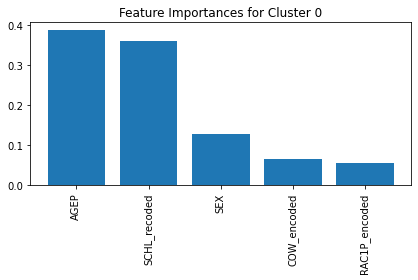

/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/2968599511.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


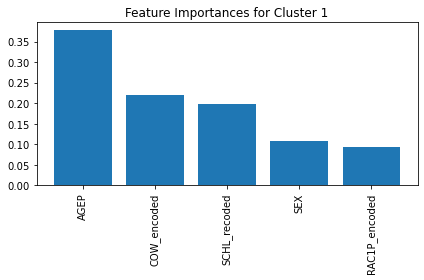

/var/folders/99/y8t3mn815dg3vh6sq5xh_6cc0000h3/T/ipykernel_33380/2968599511.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


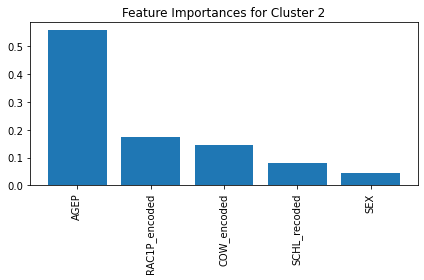

In [53]:
for i in range(3):
    
    data_rac = data2.loc[data2['Cluster'] == i]

    X = data_rac[["RAC1P_encoded", "SEX", "AGEP", "COW_encoded", "SCHL_recoded"]]
    y = data_rac[["INCOME"]]

    rf = RandomForestRegressor(n_estimators=30)
    rf.fit(X, y)

    importances = rf.feature_importances_
    feature_names = X.columns
    indices = importances.argsort()[::-1]
    plt.figure()
    plt.title("Feature Importances for Cluster " + str(i))
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.show()

- Age is most important for all incomes
- For lowest incomes, education is the second most important. These are salaries around \$43000. Race is the least important which indicates that racial discrimination is least present in low income jobs, but still present none the less.
- For incomes around \$133000, education is no longer the second most important, class of worker is. 
- Race has the second biggest impact in high income jobs around \$500,000 a year indicating that racial discrimination is most present in these high income jobs.

# Community Approach

In [54]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

grouped = data.groupby(['PUMA'])

gini_index = grouped['INCOME'].apply(gini).reset_index()

gini_index.rename(columns={"INCOME": "gini_index"}, inplace = True)

In [55]:
com2 = data[['PUMA', 'RAC1P', 'income_percent']]

In [56]:
com3 = com2.groupby(['RAC1P', 'PUMA'])['RAC1P'].count()
com3 = com3.to_frame().rename(columns={'RAC1P': 'count'}).reset_index()

In [57]:
com4 = com2.groupby(['PUMA'])['RAC1P'].count()

com4 = com4.to_frame()

In [58]:
com5 = com3.merge(com4, on='PUMA', how='left')
com5.head()

,RAC1P_x,PUMA,count,RAC1P_y
0,Asian,100,779,29404
1,Asian,101,557,8956
2,Asian,102,663,10680
3,Asian,103,501,8399
4,Asian,104,200,5420


In [59]:
com5['PER'] = com5['count'] / com5['RAC1P_y']
com5.head()

,RAC1P_x,PUMA,count,RAC1P_y,PER
0,Asian,100,779,29404,0.026493
1,Asian,101,557,8956,0.062193
2,Asian,102,663,10680,0.062079
3,Asian,103,501,8399,0.059650
4,Asian,104,200,5420,0.036900


In [60]:
com5.sort_values(by=['PUMA'])

div = com5

In [61]:
com5.rename(columns={"RAC1P_x": "RAC1P"}, inplace = True)
com5 = com5[['RAC1P', 'PUMA', 'PER']]
com5.head()

,RAC1P,PUMA,PER
0,Asian,100,0.026493
1,Asian,101,0.062193
2,Asian,102,0.062079
3,Asian,103,0.059650
4,Asian,104,0.036900


In [62]:
com5 = pd.pivot(com5, index=['PUMA'], columns = 'RAC1P',values = 'PER')

com5.head()

RAC1P,Asian,Black,Other,White
PUMA,,,,
100,0.026493,0.027513,0.128826,0.817168
101,0.062193,0.079165,0.145042,0.713600
102,0.062079,0.092978,0.142135,0.702809
103,0.059650,0.087749,0.165258,0.687344
104,0.036900,0.165129,0.159410,0.638561


In [63]:
com5 = pd.merge(gini_index, com5,  how='left', left_on=['PUMA'], right_on = ['PUMA'])

com5 = com5.dropna()

com5.sort_values(by=['PUMA'])

,PUMA,gini_index,Asian,Black,Other,White
0,100,0.403097,0.026493,0.027513,0.128826,0.817168
1,101,0.487508,0.062193,0.079165,0.145042,0.713600
2,102,0.450970,0.062079,0.092978,0.142135,0.702809
3,103,0.466045,0.059650,0.087749,0.165258,0.687344
4,104,0.393235,0.036900,0.165129,0.159410,0.638561
...,...,...,...,...,...,...
977,59308,0.454532,0.217391,0.027174,0.103261,0.652174
978,59309,0.413735,0.294807,0.061977,0.125628,0.517588
979,70101,0.433708,0.019608,0.001961,0.039216,0.939216
980,70201,0.422565,0.067669,0.005639,0.062030,0.864662


In [64]:
for col in com5.columns:
    print(col)

PUMA
gini_index
Asian
Black
Other
White


In [65]:
model = ols(formula='gini_index ~ Asian + Black + White + Other', data=com5)
print(type(model))

<class 'statsmodels.regression.linear_model.OLS'>


In [66]:
model = model.fit()
print(type(model))
print(model.summary())

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
                            OLS Regression Results                            
Dep. Variable:             gini_index   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     80.51
Date:                Wed, 03 May 2023   Prob (F-statistic):           1.63e-46
Time:                        18:16:09   Log-Likelihood:                 1717.8
No. Observations:                 974   AIC:                            -3428.
Df Residuals:                     970   BIC:                            -3408.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

Does not yield any useful information which makes sense. We should not expect that with the percentage of black individuals increasing in a community, the income inequality to increase. Whilst this community may have a lower income, this doesn't infer that the income is distributed unevenly. Another question might be: what racial composition of a community has the most income inequality?

# Optimal Inequality

<AxesSubplot:ylabel='Density'>

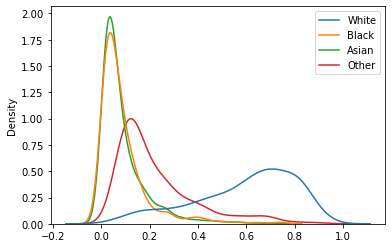

In [67]:
wag = com5[["White", "Black", "Asian", "Other"]]

sns.kdeplot(data=wag)

In [68]:
com5.sort_values(by=['gini_index'])

,PUMA,gini_index,Asian,Black,Other,White
770,8606,0.282951,0.003413,0.426621,0.457338,0.112628
384,3528,0.295344,0.004310,0.642241,0.306034,0.047414
434,3741,0.296230,0.013944,0.001992,0.894422,0.089641
22,122,0.296532,0.024390,0.045732,0.704268,0.225610
905,35003,0.300672,0.054845,0.012797,0.330896,0.601463
...,...,...,...,...,...,...
420,3727,0.534957,0.081949,0.018826,0.118494,0.780731
250,2311,0.535681,0.068306,0.016393,0.269126,0.646175
746,8106,0.537011,0.171821,0.022337,0.268041,0.537801
536,4613,0.544674,0.158287,0.093110,0.158287,0.590317


By looking at the data we can see that there is no consistency that we can infer there is a certain percentage of races which leads to income inequality. Between the highest and second highest gini index, there is large different in % for all races.

# Diversity

In [69]:
div.head()

,RAC1P,PUMA,count,RAC1P_y,PER
0,Asian,100,779,29404,0.026493
1,Asian,101,557,8956,0.062193
2,Asian,102,663,10680,0.062079
3,Asian,103,501,8399,0.059650
4,Asian,104,200,5420,0.036900


In [70]:
div.rename(columns={"RAC1P_x": "RAC1P"}, inplace = True)
div = div[['RAC1P', 'PUMA', 'count',]]
div = pd.pivot(div, index=['PUMA'], columns = 'RAC1P',values = 'count')
div.head()

RAC1P,Asian,Black,Other,White
PUMA,,,,
100,779.0,809.0,3788.0,24028.0
101,557.0,709.0,1299.0,6391.0
102,663.0,993.0,1518.0,7506.0
103,501.0,737.0,1388.0,5773.0
104,200.0,895.0,864.0,3461.0


In [71]:
proportions = div[['Other', 'Black', 'Asian', 'White']].div(div[['Other', 'Black', 'Asian', 'White']].sum(axis=1), axis=0)

gini_simpson_index = 1 - np.sum(np.square(proportions), axis=1)

div['GS_index'] = gini_simpson_index

div = pd.merge(gini_index, div,  how='left', left_on=['PUMA'], right_on = ['PUMA'])

div.head()

,PUMA,gini_index,Asian,Black,Other,White,GS_index
0,100,0.403097,779.0,809.0,3788.0,24028.0,0.314182
1,101,0.487508,557.0,709.0,1299.0,6391.0,0.459603
2,102,0.450970,663.0,993.0,1518.0,7506.0,0.473359
3,103,0.466045,501.0,737.0,1388.0,5773.0,0.488991
4,104,0.393235,200.0,895.0,864.0,3461.0,0.538199


In [72]:
_max= div[['Other', 'Black', 'Asian', 'White']].idxmax(axis=1)

div["max"] = _max

div.head()

,PUMA,gini_index,Asian,Black,Other,White,GS_index,max
0,100,0.403097,779.0,809.0,3788.0,24028.0,0.314182,White
1,101,0.487508,557.0,709.0,1299.0,6391.0,0.459603,White
2,102,0.450970,663.0,993.0,1518.0,7506.0,0.473359,White
3,103,0.466045,501.0,737.0,1388.0,5773.0,0.488991,White
4,104,0.393235,200.0,895.0,864.0,3461.0,0.538199,White


In [73]:
div['max'].unique()

array(['White', 'Asian', 'Other', 'Black'], dtype=object)

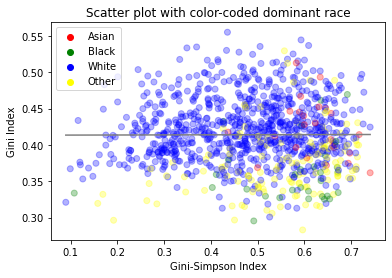

In [74]:
color_map = {'Asian': 'red', 'Black': 'green', 'White': 'blue', 'Other':'yellow'}
colors = div['max'].map(color_map)

plt.scatter(div["GS_index"], div["gini_index"], c = colors, alpha = 0.3)
plt.ticklabel_format(style='plain')

handles = [plt.scatter([], [], c=color_map[key], label=key) for key in color_map]
labels = color_map.keys()

plt.legend(handles=handles, labels=labels)

plt.title('Scatter plot with color-coded dominant race')
plt.xlabel('Gini-Simpson Index')
plt.ylabel('Gini Index')

coefficients = np.polyfit(div['GS_index'], div['gini_index'], 1)
m = coefficients[0]
b = coefficients[1]

x_values = np.linspace(div['GS_index'].min(), div['GS_index'].max())
y_values = m * x_values + b
plt.plot(x_values, y_values, color='grey')

1: no diversity, 0:total diversity.... its the probability that if you pick two people at random, they are of the same race

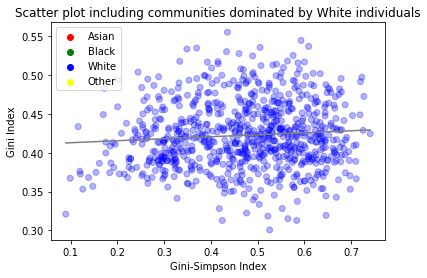

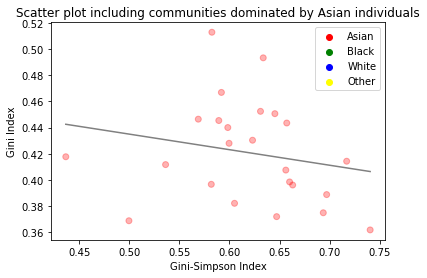

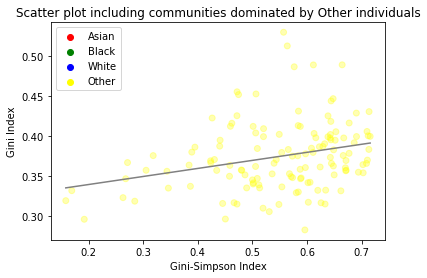

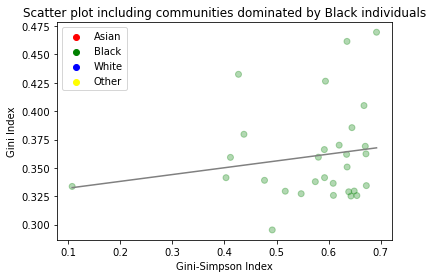

In [75]:
for i in div['max'].unique():

    div2 = div[div['max'] == i]

    color_map = {'Asian': 'red', 'Black': 'green', 'White': 'blue', 'Other':'yellow'}
    colors = div2['max'].map(color_map)

    plt.scatter(div2["GS_index"], div2["gini_index"], c = colors, alpha = 0.3)
    plt.ticklabel_format(style='plain')

    handles = [plt.scatter([], [], c=color_map[key], label=key) for key in color_map]
    labels = color_map.keys()

    # add the legend to the plot
    plt.legend(handles=handles, labels=labels)

    # set the plot title and labels
    plt.title('Scatter plot including communities dominated by ' + i + ' individuals')
    plt.xlabel('Gini-Simpson Index')
    plt.ylabel('Gini Index')

    coefficients = np.polyfit(div2['GS_index'], div2['gini_index'], 1)
    m = coefficients[0]
    b = coefficients[1]

    # create the regression line
    x_values = np.linspace(div2['GS_index'].min(), div2['GS_index'].max())
    y_values = m * x_values + b
    plt.plot(x_values, y_values, color='grey')
    plt.show()

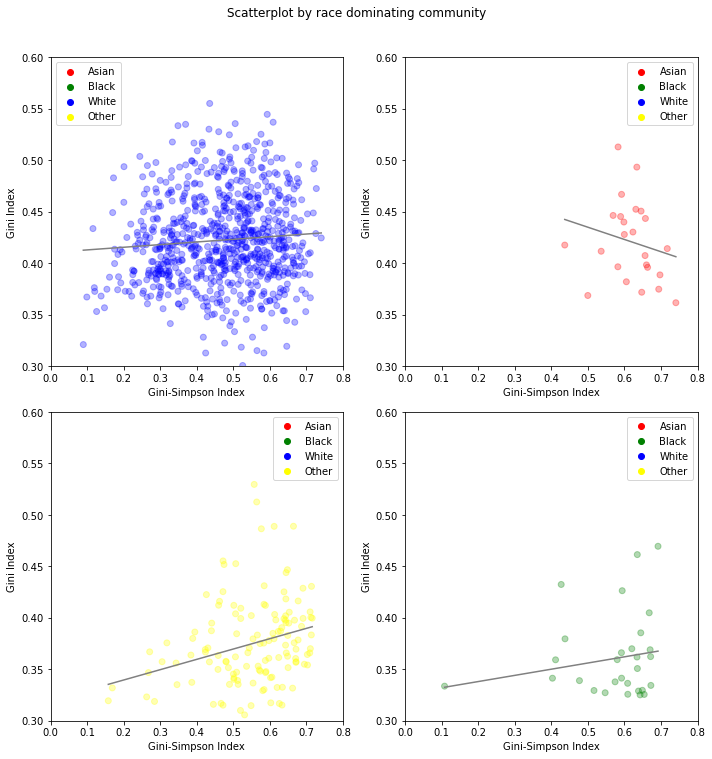

In [76]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

xlim = (0, 0.8)
ylim = (0.3, 0.6)
for ax in axs.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

for i, ax in zip(div['max'].unique(), axs.flatten()):
    div2 = div[div['max'] == i]

    color_map = {'Asian': 'red', 'Black': 'green', 'White': 'blue', 'Other':'yellow'}
    colors = div2['max'].map(color_map)

    ax.scatter(div2["GS_index"], div2["gini_index"], c=colors, alpha=0.3)
    ax.ticklabel_format(style='plain')

    handles = [ax.scatter([], [], c=color_map[key], label=key) for key in color_map]
    labels = color_map.keys()

    # add the legend to the plot
    ax.legend(handles=handles, labels=labels)

    # set the plot title and labels
    ax.set_xlabel('Gini-Simpson Index')
    ax.set_ylabel('Gini Index')

    coefficients = np.polyfit(div2['GS_index'], div2['gini_index'], 1)
    m = coefficients[0]
    b = coefficients[1]

    # create the regression line
    x_values = np.linspace(div2['GS_index'].min(), div2['GS_index'].max())
    y_values = m * x_values + b
    ax.plot(x_values, y_values, color='grey')

plt.tight_layout()
plt.suptitle("Scatterplot by race dominating community", y=1.05)
plt.show()

- We see that communities dominated by Black and Other races, as they approach an equilibria where the each races compromises 25% of the community, we see the gini index increases. In other words, these communities which are dominated by these races, as their frequency decreases it leads to more income inequality. Communities which are dominated by Black and Other races tend to have better income inequality. The opposite can be said for White and Asian individuals. This is due to Black and Other races earning less money on average and such these communities have less variation in spread of income and better equality.

In [77]:
div.head()

,PUMA,gini_index,Asian,Black,Other,White,GS_index,max
0,100,0.403097,779.0,809.0,3788.0,24028.0,0.314182,White
1,101,0.487508,557.0,709.0,1299.0,6391.0,0.459603,White
2,102,0.450970,663.0,993.0,1518.0,7506.0,0.473359,White
3,103,0.466045,501.0,737.0,1388.0,5773.0,0.488991,White
4,104,0.393235,200.0,895.0,864.0,3461.0,0.538199,White


In [78]:
div2 = div[div['max'] == 'White']

div2.head()

,PUMA,gini_index,Asian,Black,Other,White,GS_index,max
0,100,0.403097,779.0,809.0,3788.0,24028.0,0.314182,White
1,101,0.487508,557.0,709.0,1299.0,6391.0,0.459603,White
2,102,0.450970,663.0,993.0,1518.0,7506.0,0.473359,White
3,103,0.466045,501.0,737.0,1388.0,5773.0,0.488991,White
4,104,0.393235,200.0,895.0,864.0,3461.0,0.538199,White


In [79]:
com5.head()

,PUMA,gini_index,Asian,Black,Other,White
0,100,0.403097,0.026493,0.027513,0.128826,0.817168
1,101,0.487508,0.062193,0.079165,0.145042,0.713600
2,102,0.450970,0.062079,0.092978,0.142135,0.702809
3,103,0.466045,0.059650,0.087749,0.165258,0.687344
4,104,0.393235,0.036900,0.165129,0.159410,0.638561


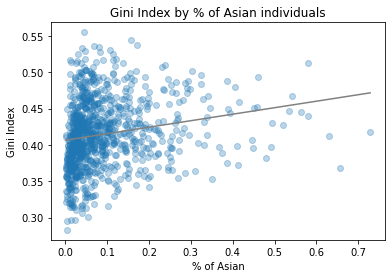

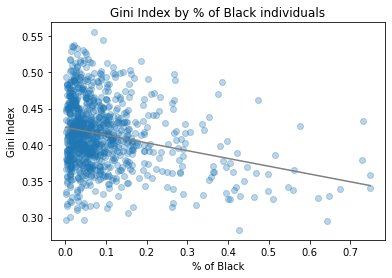

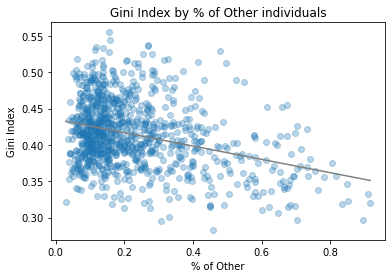

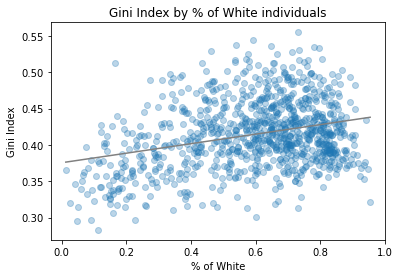

In [80]:
var = ["Asian", "Black", "Other", "White"]

for i in var:
    plt.scatter(com5[i], com5["gini_index"], alpha = 0.3)
    plt.ticklabel_format(style='plain')
    
    plt.title('Gini Index by % of ' + i + ' individuals')
    plt.xlabel('% of ' + i)
    plt.ylabel('Gini Index')
    
    coefficients = np.polyfit(com5[i], com5['gini_index'], 1)
    m = coefficients[0]
    b = coefficients[1]

    # create the regression line
    x_values = np.linspace(com5[i].min(), com5[i].max())
    y_values = m * x_values + b
    plt.plot(x_values, y_values, color='grey')
    
    plt.show()

- We see the same trend here

In [81]:
com5 = com5.merge(pincp_data, on='PUMA', how='left')

com5.head()

,PUMA,gini_index,Asian,Black,Other,White,income_median_PUMA
0,100,0.403097,0.026493,0.027513,0.128826,0.817168,42021.0624
1,101,0.487508,0.062193,0.079165,0.145042,0.713600,51496.4000
2,102,0.450970,0.062079,0.092978,0.142135,0.702809,52526.3280
3,103,0.466045,0.059650,0.087749,0.165258,0.687344,56646.0400
4,104,0.393235,0.036900,0.165129,0.159410,0.638561,46346.7600


Text(0, 0.5, 'Gini Index of PUMA')

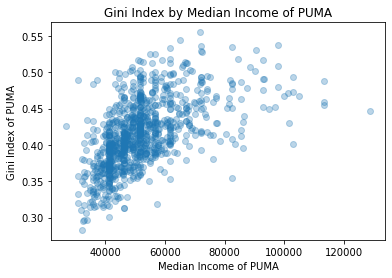

In [82]:
plt.scatter(com5["income_median_PUMA"], com5["gini_index"], alpha = 0.3)
plt.ticklabel_format(style='plain')
    
plt.title('Gini Index by Median Income of PUMA')    
plt.xlabel("Median Income of PUMA")
plt.ylabel('Gini Index of PUMA')

- Communities with lower incomes tend to have a better equality score
- Reapproaching this, I would weight income to normalize gini index score across different incomes of PUMAs
- Fit a lognorm distribution and rescale to standardize data